In [1]:
from datetime import datetime, timedelta
from itertools import product
import numpy as np
from scipy.stats import gmean
import yfinance as yf
from matplotlib import pyplot as plt

In [2]:
tickers = [
    'WMT', 'MSFT', 'CAT', 'LLY', 'NKE',
]

start = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')
end = datetime.now().strftime('%Y-%m-%d')
interval = '1wk'

dfs = yf.download(tickers, start=start, end=end, interval=interval)

[*********************100%%**********************]  5 of 5 completed


In [3]:
# returns
weekly_returns = dfs['Adj Close'].pct_change().dropna()
average_weekly_returns = gmean(weekly_returns+1) - 1
annual_returns = (1 + average_weekly_returns)**52 - 1

# covatiance
weekly_cov = dfs['Adj Close'].pct_change().dropna().cov()
annual_cov = weekly_cov * 52

# define matrices
TICKERS = dfs['Adj Close'].columns
EXP_RETURNS = annual_returns
COV_MATRIX = annual_cov.to_numpy()
ONES = np.ones(len(TICKERS))

In [4]:
for i, ticker in enumerate(TICKERS):
    print(f'{ticker}:')
    print(f'Expected Return: {100*EXP_RETURNS[i]:.2f}%')
    print(f'{ticker} Standard Deviation: {100*np.sqrt(COV_MATRIX[i][i]):.2f}% \n')

CAT:
Expected Return: 14.77%
CAT Standard Deviation: 29.64% 

LLY:
Expected Return: 32.81%
LLY Standard Deviation: 26.21% 

MSFT:
Expected Return: 28.54%
MSFT Standard Deviation: 23.63% 

NKE:
Expected Return: 10.63%
NKE Standard Deviation: 27.95% 

WMT:
Expected Return: 12.72%
WMT Standard Deviation: 20.27% 



In [5]:
# calculate a bunch of possible portfolios
step_size = 0.05
decimals = len(str(step_size).split('.')[1])
possible_weights = np.arange(0, 1+step_size, step_size)

# generate all possible weight combinations
weight_combinations = list(product(possible_weights, repeat=len(TICKERS)))

# remove combinations that dont sum to 1
weights = []
for w in weight_combinations:
    w = np.round(w, decimals)
    if np.sum(w) == 1:
        weights.append(w)
        
# for each weight combination, calculate expected return and standard deviation
portfolios = {
    'weights': weights,
    'expected_returns': [],
    'standard_deviation': []
}

for w in weights:
    exp_returns = np.dot(w, annual_returns)
    std_returns = np.sqrt(np.dot(w, np.dot(COV_MATRIX, w)))

    portfolios['expected_returns'].append(np.round(exp_returns, 4))
    portfolios['standard_deviation'].append(np.round(std_returns, 4))

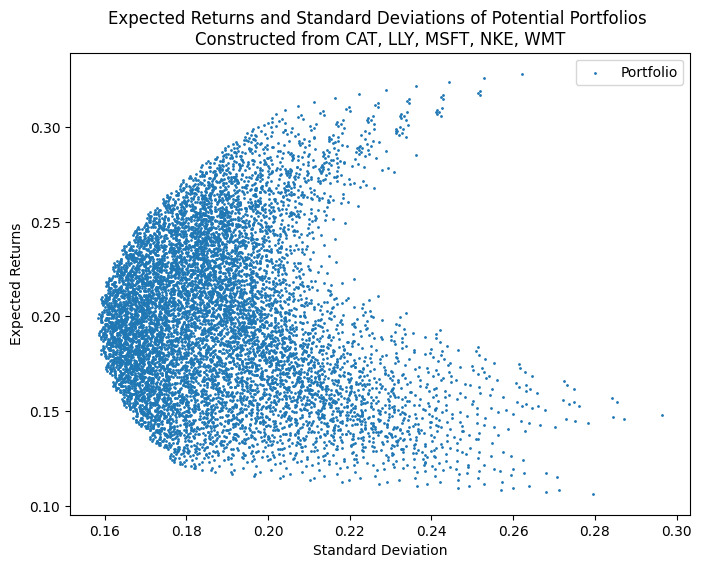

In [21]:
# Plot
plt.figure(figsize=(8,6))
plt.scatter(portfolios['standard_deviation'], portfolios['expected_returns'], s=1, label='Portfolio')
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.title(
    f'Expected Returns and Standard Deviations of Potential Portfolios \n'
    f'Constructed from {", ".join(TICKERS)}'
)
plt.legend()
plt.show()

### Efficient Frontier
#### Weights of portfolios along Efficient Frontier ($\omega_{\mu_P}$) are defined by:

$$
\bm{\omega}_{\mu_p} = \bm{g} + \mu_P \bm{h} \quad (1)
$$

Where:

$$
\bm{g} = \frac{B}{D}\Omega^{-1}\bm{1} - \frac{A}{D}\Omega^{-1}\mu \quad (2)
$$

$$
\bm{h} = \frac{C}{D}\Omega^{-1}\mu - \frac{A}{D}\Omega^{-1}\bm{1} \quad (3)
$$

And:

$$
A = \mu^T \Omega^{-1} \bm{1} \quad (4)
$$

$$
B = \mu^T \Omega^{-1} \mu \quad (5)
$$

$$
C = \bm{1}^T \Omega^{-1} \bm{1} \quad (6)
$$

$$
D = BC-A^2 \quad (7)
$$

$\mu$ is the $1\text{x}n$ matrix of expected returns, **1** is a $1\text{x}n$ of 1s, and $\Omega^{-1}$ is the inverse of the $n\text{x}n$ Covariance Matrix of stocks...

In [7]:
cov_inv = np.linalg.inv(COV_MATRIX)

a = np.dot(ONES, np.dot(cov_inv, EXP_RETURNS))
b = np.dot(EXP_RETURNS, np.dot(cov_inv, EXP_RETURNS))
c = np.dot(ONES, np.dot(cov_inv, ONES))
d = b*c - a**2

g = b/d * np.dot(cov_inv, ONES) - a/d * np.dot(cov_inv, EXP_RETURNS)
h = c/d * np.dot(cov_inv, EXP_RETURNS) - a/d * np.dot(cov_inv, ONES)

# generate possible returns
mu_r = np.linspace(np.min(EXP_RETURNS), np.max(EXP_RETURNS)*1.2, 100)

# calculate weights
w_p = [g + mu * h for mu in mu_r]

# calculate standard deviation
std_r = [np.sqrt(np.dot(w, np.dot(COV_MATRIX, w))) for w in w_p]

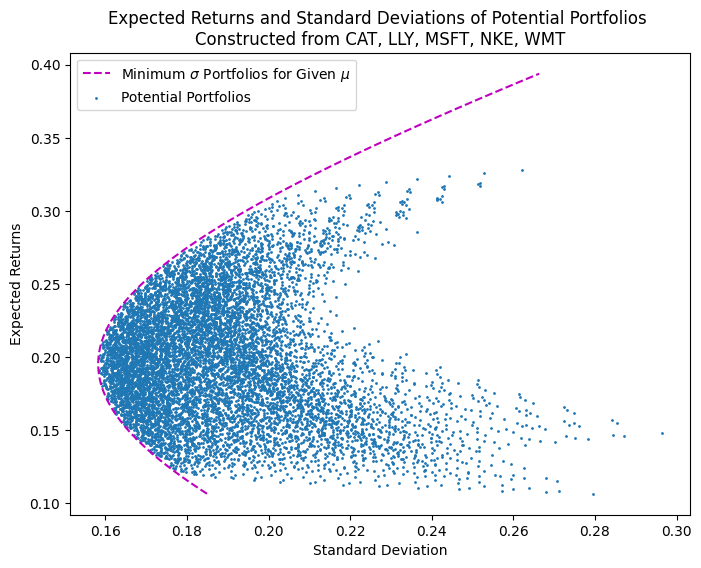

In [24]:
# Plot
plt.figure(figsize=(8,6))
plt.plot(std_r, mu_r, color='m', linestyle='--', label=rf'Minimum $\sigma$ Portfolios for Given $\mu$')
plt.scatter(portfolios['standard_deviation'], portfolios['expected_returns'], s=1, label='Potential Portfolios')
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.title(
    f'Expected Returns and Standard Deviations of Potential Portfolios \n'
    f'Constructed from {", ".join(TICKERS)}'
)
plt.legend()
plt.show()

### Minimum Variance Portfolio
#### Variance and Returns of minimum variance portfolio can be found by:

$$
\mu_{min} = -\frac{\bm{g}^T \Omega \bm{h}}{\bm{h}^T \Omega \bm{h}} \quad (8)
$$

$$
Var(R_{min}) = \bm{g}^T \Omega \bm{g} - \frac{(\bm{g}^T \Omega \bm{h})^2}{\bm{h}^T \Omega \bm{h}} \quad (9)
$$

In [8]:
mu_min = -np.dot(g, np.dot(COV_MATRIX, h)) / np.dot(h, np.dot(COV_MATRIX, h))
std_min = np.sqrt(np.dot(g, np.dot(COV_MATRIX, g)) - np.dot(g, np.dot(COV_MATRIX, h))**2 / np.dot(h, np.dot(COV_MATRIX, h)))

w_std_min = g + mu_min * h

In [9]:
print(f'Minimum Standard Deviation Portfolio:')
print(f'Expected Returns: {100*mu_min:.2f}%')
print(f'Standard Deviation: {100*std_min:.2f}%')
print(f'Weights:')
for t, w in zip(TICKERS, w_std_min):
    print(f'{t}: {100*w:.2f}%')

Minimum Standard Deviation Portfolio:
Expected Returns: 19.50%
Standard Deviation: 15.82%
Weights:
CAT: 9.78%
LLY: 20.66%
MSFT: 16.89%
NKE: 11.65%
WMT: 41.03%


In [10]:
# efficient frontier
mu_eff = [r for r in mu_r if r >= mu_min]
std_eff = [std for r, std in zip(mu_r, std_r) if r >= mu_min]
w_eff = [w for r, w in zip(mu_r, w_p) if r >= mu_min]

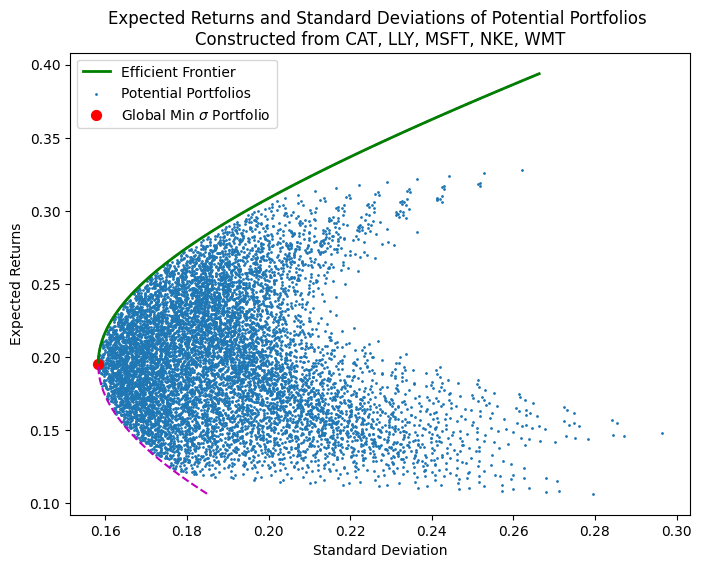

In [25]:
# Plot
plt.figure(figsize=(8,6))
plt.plot(std_r, mu_r, color='m', linestyle='--')
plt.plot(std_eff, mu_eff, color='g', label='Efficient Frontier', linestyle='-', linewidth=2.0)
plt.scatter(portfolios['standard_deviation'], portfolios['expected_returns'], s=1, label='Potential Portfolios')
plt.scatter(std_min, mu_min, color='r', marker='o', s=50, label=rf'Global Min $\sigma$ Portfolio')
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.title(
    f'Expected Returns and Standard Deviations of Potential Portfolios \n'
    f'Constructed from {", ".join(TICKERS)}'
)
plt.legend()
plt.show()

In [27]:
# point along efficient frontier
w_point = g + 0.35 * h
print(rf'weights of portfolio on efficient frontier ($\mu=0.35$):')
for t, w in zip(TICKERS, w_point):
    print(f'{t}: {100*w:.2f}%')

weights of portfolio on efficient frontier ($\mu$ = 0.35$):
CAT: 3.17%
LLY: 57.13%
MSFT: 64.99%
NKE: -21.93%
WMT: -3.35%


### Tangent Portfolio
#### Weights of the tangent portfolio can be found by:

$$
\omega_T = \frac{\bar{\omega}}{\bm{1}^T \bar{\omega}} \quad (10)
$$

Where:

$$
\bar{\omega} = \Omega^{-1} (\mu-\mu_f \bm{1}) \quad (11)
$$

$(\mu-\mu_f \bm{1})$ is also known as the excess returns. It measures how much returns we can get by taking on risk.

In [13]:
mu_f = 0.0425
mu_ex = EXP_RETURNS - mu_f
w_bar = np.dot(cov_inv, (mu_ex * ONES))
w_t = w_bar / np.dot(ONES, w_bar)

mu_t = np.dot(EXP_RETURNS, w_t)
std_t = np.sqrt(np.dot(w_t, np.dot(COV_MATRIX, w_t)))

In [14]:
# tangent portfolio
print(f'Tangent Portfolio constructed with {", ".join(TICKERS)}:')
print(f'Expected Returns: {100*mu_t:.2f}%')
print(f'Standard Deviation: {100*std_t:.2f}%')
print('Weights:')
for t, w in zip(TICKERS, w_t):
    print(f'{t}: {100*w:.2f}%')

Tangent Portfolio constructed with CAT, LLY, MSFT, NKE, WMT:
Expected Returns: 33.63%
Standard Deviation: 21.96%
Weights:
CAT: 3.76%
LLY: 53.89%
MSFT: 60.72%
NKE: -18.95%
WMT: 0.58%


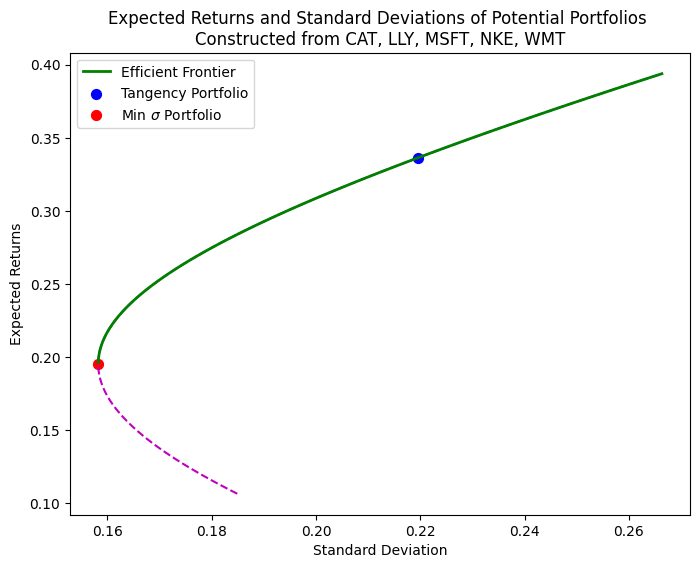

In [15]:
# Plot
plt.figure(figsize=(8,6))
plt.plot(std_r, mu_r, color='m', linestyle='--')
plt.plot(std_eff, mu_eff, color='g', label='Efficient Frontier', linestyle='-', linewidth=2.0)
plt.scatter(std_t, mu_t, color='b', marker='o', s=50, label='Tangency Portfolio')
plt.scatter(std_min, mu_min, color='r', marker='o', s=50, label=rf'Min $\sigma$ Portfolio')
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.title(
    f'Expected Returns and Standard Deviations of Potential Portfolios \n'
    f'Constructed from {", ".join(TICKERS)}'
)
plt.legend()
plt.show()

### Capital Market Line

This problem now becomes a 1 risky asset (the tangent portfolio) and 1 risk free asset question. To figure out the best portfolio for a desired return, we can just figure out the weights of each asset...

Sharpe's ratio can be found using:

$$
c_p = \frac{\mu_p - \mu_f}{(\mu-\mu_f \bm{1})^T \Omega^{-1} (\mu-\mu_f \bm{1})} \quad (12)
$$

where $\mu_p$ is the expected return of the portfolio, and $\mu_f$ is the risk free rate of return.

We can then use $c_p(\bm{1}^T \bar{\omega})$ to determine how much weight we should put on the tangent portfolio to achieve the desired $\mu_p$

The standard deviation for the desired expected return can be found using:

$$
\sigma_p = \sqrt{c_p^2\bar{\omega} \Omega \bar{\omega}^T} \enspace (13)
$$

In [16]:
# generate possible returns
mu_p = np.linspace(mu_f, mu_t, 100)

c_p = (mu_p - mu_f) / (np.dot(mu_ex, np.dot(cov_inv, mu_ex)))
std_p = [np.sqrt(c**2 * np.dot(w_bar, np.dot(COV_MATRIX, w_bar))) for c in c_p]

In [17]:
# ex: 80-20 split
mu_80_20 = 0.8 * mu_t + 0.2 * mu_f
c_p_80_20 = (mu_80_20 - mu_f) / (np.dot(mu_ex, np.dot(cov_inv, mu_ex)))
std_80_20 = np.sqrt(c_p_80_20**2 * np.dot(w_bar, np.dot(COV_MATRIX, w_bar)))

# 60-20 split
mu_60_40 = 0.6 * mu_t + 0.4 * mu_f
c_p_60_40 = (mu_60_40 - mu_f) / (np.dot(mu_ex, np.dot(cov_inv, mu_ex)))
std_60_40 = np.sqrt(c_p_60_40**2 * np.dot(w_bar, np.dot(COV_MATRIX, w_bar)))

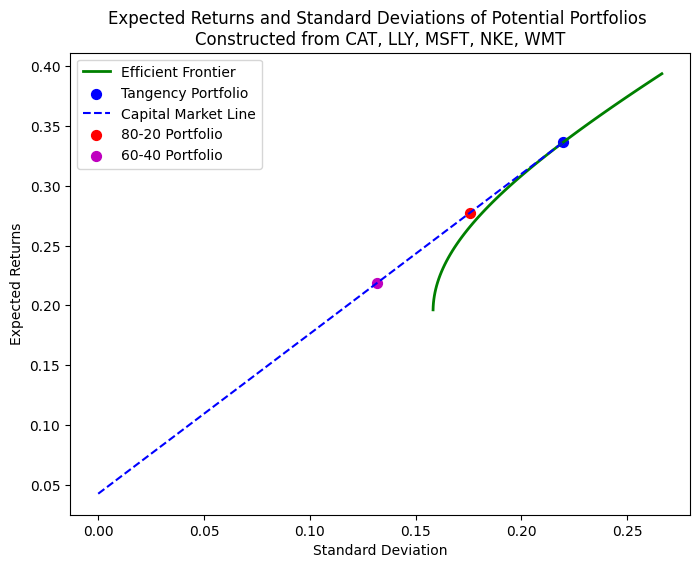

In [18]:
# Plot
plt.figure(figsize=(8,6))
plt.plot(std_eff, mu_eff, color='g', label='Efficient Frontier', linestyle='-', linewidth=2.0)
plt.scatter(std_t, mu_t, color='b', marker='o', s=50, label='Tangency Portfolio')
plt.plot(std_p, mu_p, color='b', label='Capital Market Line', linestyle='--')
plt.scatter(std_80_20, mu_80_20, color='r', marker='o', s=50, label='80-20 Portfolio')
plt.scatter(std_60_40, mu_60_40, color='m', marker='o', s=50, label='60-40 Portfolio')
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.title(
    f'Expected Returns and Standard Deviations of Potential Portfolios \n'
    f'Constructed from {", ".join(TICKERS)}'
)
plt.legend()
plt.show()

In [19]:
print(f'80-20 portfolio:')
print(f'Expected Returns: {100*mu_80_20:.2f}%')
print(f'Standard Deviation: {100*std_80_20:.2f}%')

80-20 portfolio:
Expected Returns: 27.75%
Standard Deviation: 17.57%


In [20]:
print(f'60-40 portfolio:')
print(f'Expected Returns: {100*mu_60_40:.2f}%')
print(f'Standard Deviation: {100*std_60_40:.2f}%')

60-40 portfolio:
Expected Returns: 21.88%
Standard Deviation: 13.18%
